# Music Genre Classification

Music genres classification is significant topic to investigate as the genres are one of the few and most valuable tools we have for comprehending and analyzing the works of artists. These classifications have the capacity to significantly improve our knowledge, recognition, and pleasure of the music we hear when utilized flexibly and descriptively. Music categorization makes it easier for us to find music that suits our tastes, as well as for artists to sell their music in a way that distinguishes them from the competition.

In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
import tensorflow as tf
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible


## Loading the data:

The dataset was acquired from one of the MachineHack Hackathon [see resource](https://www.kaggle.com/purumalgi/music-genre-classification). It consists of a training dataset of 17,996 rows with 17 columns. 

In [4]:
data = pd.read_csv("train.csv")

In [5]:
data.head(30)

Artist Name  ... Class
0                                          Bruno Mars  ...     5
1                                              Boston  ...    10
2                                       The Raincoats  ...     6
3                                                Deno  ...     5
4                               Red Hot Chili Peppers  ...    10
5                                         The Stooges  ...     6
6                                       Solomon Burke  ...     2
7                                        Randy Travis  ...     4
8                           Professional Murder Music  ...     8
9                                         Dudu Aharon  ...     9
10                                      Mohammed Rafi  ...     3
11                                     Arctic Monkeys  ...    10
12                                         Eyal Golan  ...     9
13                       Harald Lassen, Bram de Looze  ...     7
14                                Buffalo Springfield  ...    10
15                                       Elmore James  ...     2
16                                        Dudu Aharon  ...     9
17                                 Velvet Two Stripes  ...    10
18                                     Eden Ben Zaken  ...     9
19                                             DaBaby  ...     5
20                                          Mura Masa  ...     6
21                               Clairmont The Second  ...     1
22                                          Krankhead  ...     5
23                                    The Stone Roses  ...    10
24                                              R3HAB  ...     9
25  IndianRaga, Akshay Anantapadmanabhan, Madhu Iy...  ...     0
26                                          MC Hammer  ...     9
27                                           duendita  ...     1
28                                            Rainbow  ...     8
29                                           fijitrip  ...     6

[30 rows x 17 columns]

In [6]:
data.shape

(17996, 17)

## Features investigating:

In [7]:
data.columns

Index(['Artist Name', 'Track Name', 'Popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'time_signature', 'Class'],
      dtype='object')

In [75]:
data["Class"].unique()

array([ 5, 10,  6,  2,  4,  8,  9,  3,  7,  1,  0])

There are 17 columns in this dataset, which can be explianed as follows:
- **Artist Name**: indicates the name of the artist 
- **Track Name**: the name of the song or piece 
- **Popularity**: is a measure of how the song is wide appeal that is typically distributed to large audiences 
- **danceability**: it describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable
- **energy**: represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy
- **key**: is the main group of pitches, or notes, that form the harmonic foundation of a piece of music
- **loudness**: it is an attribute of a sound that determines the magnitude of the auditory sensation produced 
- **mode**: a mode is the vocabulary of a melody, it specifies which notes can be used and indicates which have special importance. Of these, there are two principal notes: the final, on which the melody ends, and the dominant, which is the secondary centre.
- **speechiness**: Speechiness detects the presence of spoken words in a track. If the speechiness of a song is above 0.66, it is probably made of spoken words, a score between 0.33 and 0.66 is a song that may contain both music and words, and a score below 0.33 means the song does not have any speech.
- **acousticness**: this value describes how acoustic a song is. A score of 1.0 means the song is most likely to be an acoustic one
- **instrumentalness**: this value represents the amount of vocals in the song. The closer it is to 1.0, the more instrumental the song is
- **liveness**: this value describes the probability that the song was recorded with a live audience. According to the official documentation a value above 0.8 provides strong likelihood that the track is live
- **valence**: a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
- **tempo**: means the speed at which a piece of music should be played. As with many other musical terms, Italian words are used to describe different tempos of music. Adagio - a slow tempo (other words for slow are lento and largo) Andante - performed at a walking pace
- **duration_in min/ms**: the duration of the song in minutes or in milliseconds
- **time_signature**: indicates how many counts are in each measure and which type of note will receive one count. The top number of a time signature is commonly 2, 3, 4, or 6. The bottom number of a time signature is either 4 or 8
- **Class**: this is our target feature, that indicates the genre of a music. There are 11 classes which are:
    - 0: Acoustic/Folk 
    - 1: Alt_Music 
    - 2: Blues 
    - 3: Bollywood 
    - 4: Country
    - 5: HipHop
    - 6: Indie Alt
    - 7: Instrumental
    - 8: Metal
    - 9: Pop
    - 10: Rock



## Data cleaning:

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

It seems that there are two features of type object which are: **Artist Name** and **Track Name**.
<br> 
**Artist Name** can be removed from the dataset, as the name of the artist will not give an indication of the music genre. Also, **Track Name** can be removed form the dataset for the same reason

In [10]:
data= data.drop(["Artist Name","Track Name"], axis=1)

In [11]:
data.head()

Popularity  danceability  energy  ...  duration_in min/ms  time_signature  Class
0        60.0         0.854   0.564  ...            234596.0               4      5
1        54.0         0.382   0.814  ...            251733.0               4     10
2        35.0         0.434   0.614  ...            109667.0               4      6
3        66.0         0.853   0.597  ...            173968.0               4      5
4        53.0         0.167   0.975  ...            229960.0               4     10

[5 rows x 15 columns]

Moreover, the **duration_in min/ms** needs to be removed, beacause it gives an indication of the duration of the song with two diffierent metrics (meters and milliseconds) and it cannot be seperable.

In [12]:
data= data.drop('duration_in min/ms', axis=1)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Popularity        17568 non-null  float64
 1   danceability      17996 non-null  float64
 2   energy            17996 non-null  float64
 3   key               15982 non-null  float64
 4   loudness          17996 non-null  float64
 5   mode              17996 non-null  int64  
 6   speechiness       17996 non-null  float64
 7   acousticness      17996 non-null  float64
 8   instrumentalness  13619 non-null  float64
 9   liveness          17996 non-null  float64
 10  valence           17996 non-null  float64
 11  tempo             17996 non-null  float64
 12  time_signature    17996 non-null  int64  
 13  Class             17996 non-null  int64  
dtypes: float64(11), int64(3)
memory usage: 1.9 MB


In [14]:
data.describe()

Popularity  danceability  ...  time_signature         Class
count  17568.000000  17996.000000  ...    17996.000000  17996.000000
mean      44.512124      0.543433  ...        3.924039      6.695821
std       17.426928      0.166268  ...        0.361618      3.206073
min        1.000000      0.059600  ...        1.000000      0.000000
25%       33.000000      0.432000  ...        4.000000      5.000000
50%       44.000000      0.545000  ...        4.000000      8.000000
75%       56.000000      0.659000  ...        4.000000     10.000000
max      100.000000      0.989000  ...        5.000000     10.000000

[8 rows x 14 columns]

## Dealing with Null values:

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Popularity        17568 non-null  float64
 1   danceability      17996 non-null  float64
 2   energy            17996 non-null  float64
 3   key               15982 non-null  float64
 4   loudness          17996 non-null  float64
 5   mode              17996 non-null  int64  
 6   speechiness       17996 non-null  float64
 7   acousticness      17996 non-null  float64
 8   instrumentalness  13619 non-null  float64
 9   liveness          17996 non-null  float64
 10  valence           17996 non-null  float64
 11  tempo             17996 non-null  float64
 12  time_signature    17996 non-null  int64  
 13  Class             17996 non-null  int64  
dtypes: float64(11), int64(3)
memory usage: 1.9 MB


In [16]:
data.isnull().sum()

Popularity           428
danceability           0
energy                 0
key                 2014
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness    4377
liveness               0
valence                0
tempo                  0
time_signature         0
Class                  0
dtype: int64

It seems that **Popularity**, **key** and **instrumentalness** are the features with null values.
<br>
we can replace the null value in **Popularity** with the average value in that column. Same goes for **instrumentalness**. But as the **key** is an indication of the main group of pitches we cannot replace its null values with the mean. So, instead we will drop the null values of **key**.


In [17]:
data.Popularity.fillna(data.Popularity.mean(), inplace=True)

In [18]:
#data.instrumentalness.fillna(data.instrumentalness.mode(), inplace=True)

In [19]:
data.dropna(subset=['key'], inplace=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15982 entries, 0 to 17995
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Popularity        15982 non-null  float64
 1   danceability      15982 non-null  float64
 2   energy            15982 non-null  float64
 3   key               15982 non-null  float64
 4   loudness          15982 non-null  float64
 5   mode              15982 non-null  int64  
 6   speechiness       15982 non-null  float64
 7   acousticness      15982 non-null  float64
 8   instrumentalness  12088 non-null  float64
 9   liveness          15982 non-null  float64
 10  valence           15982 non-null  float64
 11  tempo             15982 non-null  float64
 12  time_signature    15982 non-null  int64  
 13  Class             15982 non-null  int64  
dtypes: float64(11), int64(3)
memory usage: 1.8 MB


In [21]:
data.isnull().sum()

Popularity             0
danceability           0
energy                 0
key                    0
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness    3894
liveness               0
valence                0
tempo                  0
time_signature         0
Class                  0
dtype: int64

In [22]:
data.instrumentalness.fillna(data.instrumentalness.median(), inplace=True)

In [23]:
data.isnull().sum()

Popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
Class               0
dtype: int64

In [24]:
data.describe()

Popularity  danceability  ...  time_signature         Class
count  15982.000000  15982.000000  ...    15982.000000  15982.000000
mean      44.521710      0.543770  ...        3.925917      6.697722
std       17.147453      0.166341  ...        0.358881      3.197176
min        1.000000      0.059600  ...        1.000000      0.000000
25%       33.000000      0.432000  ...        4.000000      5.000000
50%       44.000000      0.545000  ...        4.000000      8.000000
75%       56.000000      0.660000  ...        4.000000     10.000000
max      100.000000      0.989000  ...        5.000000     10.000000

[8 rows x 14 columns]

In [25]:
data.shape

(15982, 14)

So, the total data after cleaning contains 15982 rows and 14 columns

## Data Visualization: 

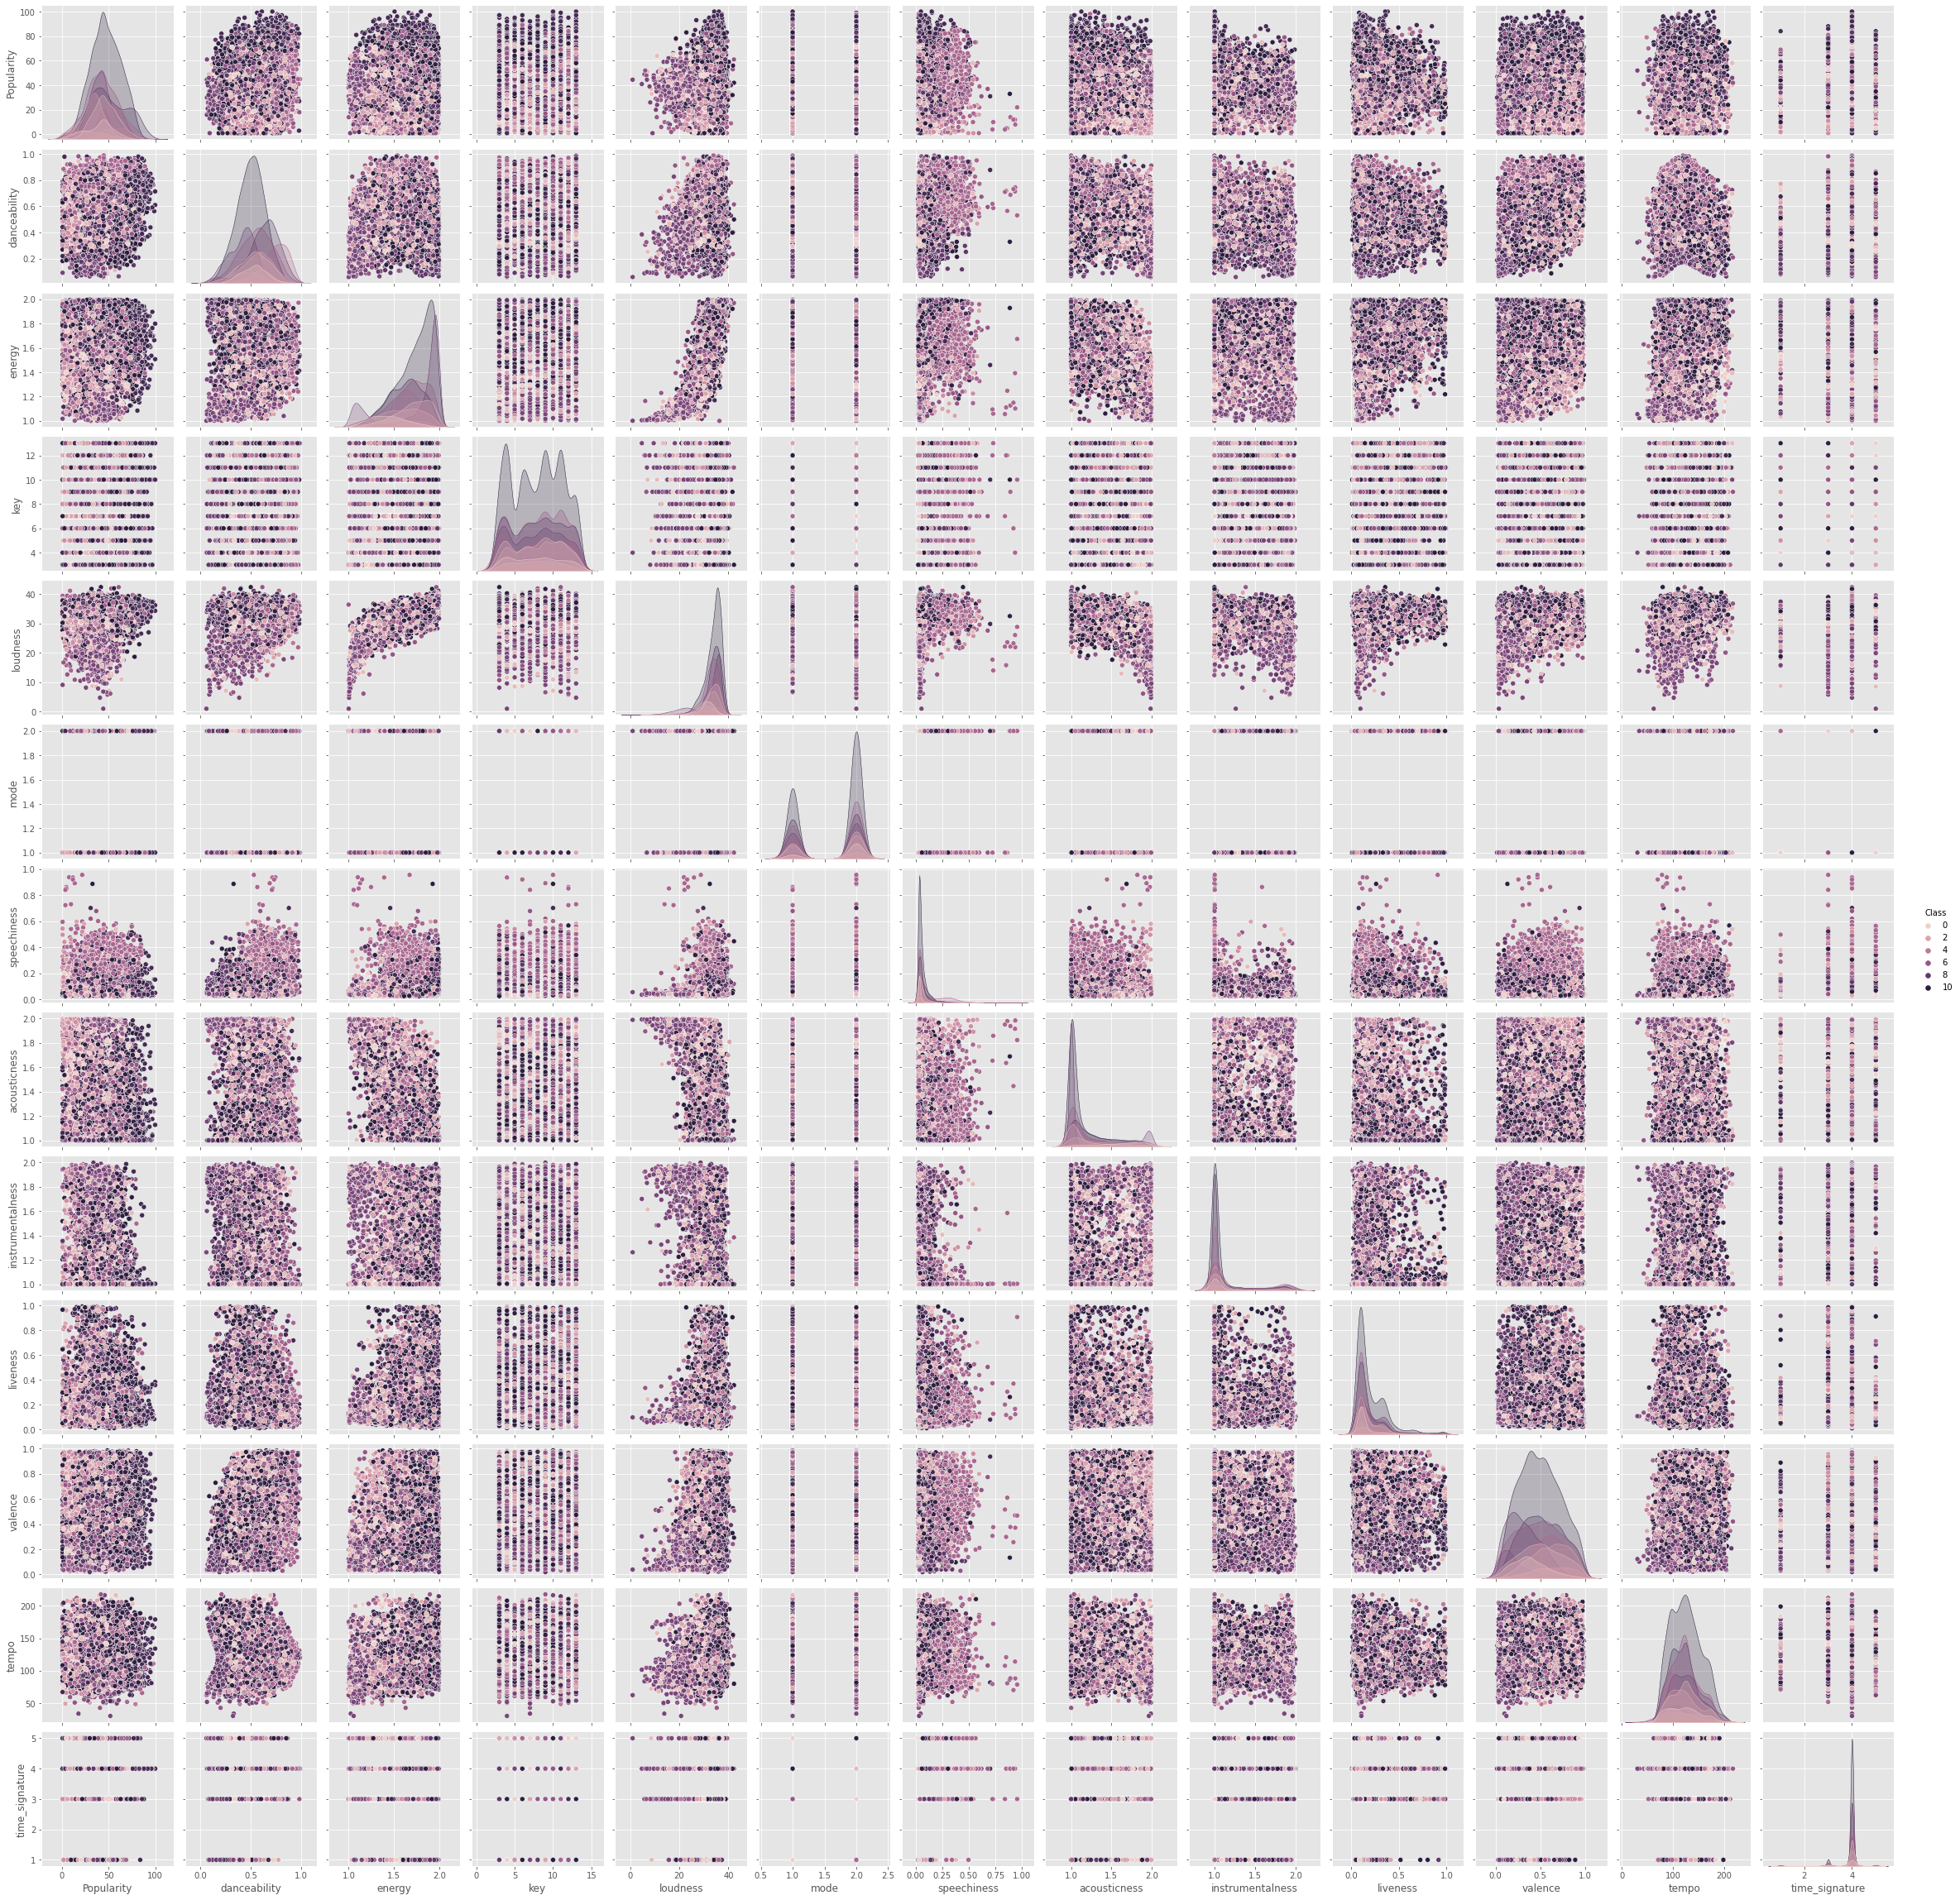

In [132]:
sns.pairplot(data, hue='Class');

Let's plot the important feature aganist the target variable **Class**, to see how much that feature influncing each class

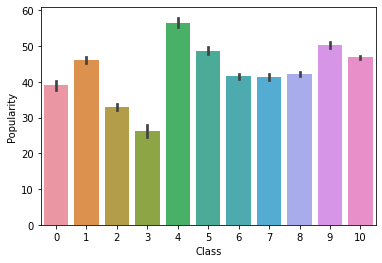

In [ ]:
sns.barplot(x = 'Class',y='Popularity',data=data);

It seems that the most popular class is 4: **Country**

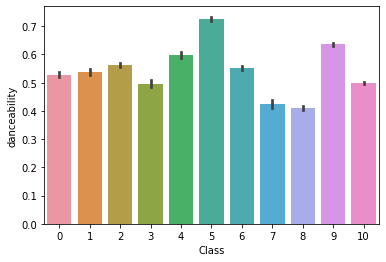

In [ ]:
sns.barplot(x = 'Class',y='danceability',data=data);

It seems that the most dancable music is class number 5: **Hiphop**

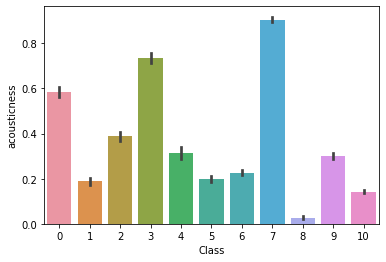

In [ ]:
sns.barplot(x = 'Class',y='acousticness',data=data);

It seems that the most acousticn class is number 7: **Instrumental**

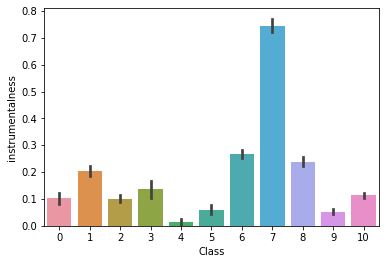

In [ ]:
sns.barplot(x = 'Class',y='instrumentalness',data=data);

It seems that the most instrumental class is also number 7: **Instrumental** , which make sense

## Dealing with Skewed features: 

**Skewed features**= energy, loudness, speechiness, acousticness, instrumentalness, livness, time_signature

1- Try to delete them and see the change in performance:
    ... The performance did not increase :(

2- Try using log to overcome skewed data(except mode and key):

In [26]:
data.columns

Index(['Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'Class'],
      dtype='object')

In [27]:
data.columns

Index(['Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'Class'],
      dtype='object')

## Data scaling:

Before scaling the data, we need to address the problem of having negative values in the **loudness** column. 
<br>
The best thing to do is to shift the data by adding all the numbers in **loudness** column with the absolute of the most negative value. Then we can scale the data as usual.

So, let's find out the most negative value (minimum vlaue) in **loudness** column

In [28]:
abs(data.loudness.min())

39.952

In [29]:
data.describe()

Popularity  danceability  ...  time_signature         Class
count  15982.000000  15982.000000  ...    15982.000000  15982.000000
mean      44.521710      0.543770  ...        3.925917      6.697722
std       17.147453      0.166341  ...        0.358881      3.197176
min        1.000000      0.059600  ...        1.000000      0.000000
25%       33.000000      0.432000  ...        4.000000      5.000000
50%       44.000000      0.545000  ...        4.000000      8.000000
75%       56.000000      0.660000  ...        4.000000     10.000000
max      100.000000      0.989000  ...        5.000000     10.000000

[8 rows x 14 columns]

I need to change energy, loudness, acousticness, instrumentalness, mode and key

I'm changing them by this equation: min()+1

In [30]:
data['loudness']=  (data['loudness'] + abs(data.loudness.min())+1)

In [31]:
data['energy']=  (data['energy'] + abs(data.energy.min())+1)

In [32]:
data['acousticness']=  (data['acousticness'] + abs(data.acousticness.min())+1)

In [33]:
data['instrumentalness']=  (data['instrumentalness'] + abs(data.instrumentalness.min())+1)

In [34]:
data['mode']=  (data['mode'] + abs(data['mode'].min())+1)

In [35]:
data['key']=  (data['key'] + abs(data['key'].min())+1)

Check the minimum value after shifting, it should be 0

In [36]:
abs(data.loudness.min())

1.0

In [37]:
data[['energy','loudness','speechiness','acousticness','instrumentalness','liveness','time_signature','key','mode']].apply(lambda x: np.log(x))

energy  loudness  speechiness  ...  time_signature       key      mode
0      0.447260  3.583186    -3.026191  ...        1.386294  1.098612  0.693147
1      0.595546  3.518150    -3.203987  ...        1.386294  1.609438  0.693147
2      0.478728  3.484864    -2.946942  ...        1.386294  2.079442  0.693147
3      0.468140  3.538754    -2.891372  ...        1.386294  2.484907  0.000000
4      0.680579  3.602041    -1.532477  ...        1.386294  1.386294  0.693147
...         ...       ...          ...  ...             ...       ...       ...
17991  0.103477  3.171868    -3.186893  ...        1.098612  2.197225  0.000000
17992  0.201323  3.426800    -3.414283  ...        1.386294  2.564949  0.000000
17993  0.683612  3.590963    -2.642262  ...        1.386294  1.791759  0.000000
17994  0.590572  3.339145    -2.009915  ...        1.386294  2.079442  0.000000
17995  0.616817  3.573244    -2.828524  ...        1.386294  1.791759  0.000000

[15982 rows x 9 columns]

In [38]:
data.head()

Popularity  danceability   energy  ...    tempo  time_signature  Class
0        60.0         0.854  1.56402  ...  134.071               4      5
1        54.0         0.382  1.81402  ...  116.454               4     10
2        35.0         0.434  1.61402  ...  147.681               4      6
3        66.0         0.853  1.59702  ...  107.033               4      5
4        53.0         0.167  1.97502  ...  199.060               4     10

[5 rows x 14 columns]

In [39]:
data.columns

Index(['Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'Class'],
      dtype='object')

Another thing before scaling, we need to split the data to X and y

## Checking data imbalance:

In [40]:
X = data.drop('Class',axis='columns')
y = data['Class']

In [41]:
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=5, n=1328 (8.309%)
Class=10, n=4377 (27.387%)
Class=6, n=2299 (14.385%)
Class=2, n=1087 (6.801%)
Class=4, n=345 (2.159%)
Class=8, n=1693 (10.593%)
Class=9, n=2221 (13.897%)
Class=3, n=371 (2.321%)
Class=7, n=489 (3.060%)
Class=1, n=1216 (7.609%)
Class=0, n=556 (3.479%)


As shown above from the results, there is data imbalanced, as Class=10 has the majority of data while Class=4 is less than the majority class by almost 4K samples. We need to do some data balancing. I'll be using SMOTE that will oversample all classes to have the same number of examples as the class with the most examples.  

In [42]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [43]:
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=5, n=4377 (9.091%)
Class=10, n=4377 (9.091%)
Class=6, n=4377 (9.091%)
Class=2, n=4377 (9.091%)
Class=4, n=4377 (9.091%)
Class=8, n=4377 (9.091%)
Class=9, n=4377 (9.091%)
Class=3, n=4377 (9.091%)
Class=7, n=4377 (9.091%)
Class=1, n=4377 (9.091%)
Class=0, n=4377 (9.091%)


Great! Now all classes are balanced

In [44]:
X.shape

(48147, 13)

In [45]:
y.shape

(48147,)

As seen above, the dataset increased the number of samples, as we used oversampling technique

Great! then we scale X dataset as usual

In [46]:
# define standard scaler
scaler = StandardScaler()

# transform data
scaled = scaler.fit_transform(X)


In [47]:
#Split data into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size=0.2, random_state=2018)

In [48]:
X_test.shape

(9630, 13)

In [49]:
X_train.shape

(38517, 13)

## K-fold cross validation(Choosing best model):

**1- Logistic Regression**

In [ ]:
reg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
l_scores = cross_val_score(reg_model, X_train, y_train)    # default 5-fold cross validation
avgScore=np.mean(l_scores)
print("[INFO] scores_logistic={}".format(l_scores))
print("[INFO] Average scores for logistic={0:.3f}".format(avgScore))

[INFO] scores_logistic=[0.5096054  0.5001298  0.50980138 0.50837336 0.5099312 ]
[INFO] Average scores for logistic=0.508


**2- Decision Trees:**

In [ ]:
d_scores = cross_val_score(DecisionTreeClassifier(), X_train, y_train)
avgScore=np.mean(d_scores)
print("[INFO] scores_logistic={}".format(d_scores))
print("[INFO] Average scores for Decision Tree ={0:.3f}".format(avgScore))

[INFO] scores_logistic=[0.58774663 0.59008307 0.60443983 0.5956121  0.5956121 ]
[INFO] Average scores for Decision Tree =0.595


**3- Random Forests:**

In [ ]:
r_scores = cross_val_score(RandomForestClassifier(n_estimators=40, criterion = 'entropy'), X_train, y_train)
avgScore=np.mean(r_scores)
print("[INFO] scores_logistic={}".format(r_scores))
print("[INFO] Average scores for Random Forest ={0:.3f}".format(avgScore))

[INFO] scores_logistic=[0.72287124 0.72975078 0.71621446 0.71997923 0.72270544]
[INFO] Average scores for Random Forest =0.722


**4- Support Vector machines:**

In [ ]:
s_scores = cross_val_score(SVC(kernel= 'poly'), X_train, y_train)
avgScore=np.mean(s_scores)
print("[INFO] scores_SVM={}".format(s_scores))
print("[INFO] Average scores for SVM ={0:.3f}".format(avgScore))

[INFO] scores_logistic=[0.57736241 0.56905504 0.57068675 0.57250422 0.57315332]
[INFO] Average scores for SVM =0.573


**5- XGBoost:**

In [ ]:
s_scores = cross_val_score(xgb.XGBClassifier(objective='multi:softprob', num_classes=11), X_train, y_train)
avgScore=np.mean(s_scores)
print("[INFO] scores_XGBoost={}".format(s_scores))
print("[INFO] Average scores for XGBoost ={0:.3f}".format(avgScore))

[INFO] scores_XGBoost=[0.58359294 0.57866044 0.58081267 0.58860184 0.58535635]
[INFO] Average scores for XGBoost =0.583


**6- Try all together:**

In [50]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [10,50,100]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    'xgboost' : {
        'model': xgb.XGBClassifier(objective='multi:softprob', num_classes=11),
        'params': {
            'objective': ["multi:softmax"],
            'n_estimators': [10, 50, 100]

        }
    }
}

In [51]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5)
    clf.fit(scaled, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    


In [58]:
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
print(df[['model','best_params']])

                 model                                        best_params
0                  svm                         {'C': 20, 'kernel': 'rbf'}
1        random_forest                              {'n_estimators': 100}
2  logistic_regression                                           {'C': 1}
3              xgboost  {'n_estimators': 100, 'objective': 'multi:soft...


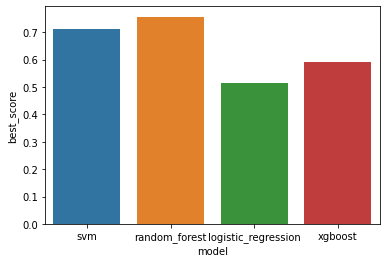

In [69]:
sns.barplot(x = 'model',y='best_score',data=df[['model','best_score']]);

## Classifying the data (using RF):

In [ ]:
""" gbm = xgb.XGBClassifier( 
                       n_estimators=3000, #arbitrary large number
                       max_depth=3,
                       objective="multi:softmax",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       num_class=11,
                       colsample_bytree=.8
                      ) 



gbm.fit( 
                    X_train, y_train, 
                    eval_metric='mlogloss',
                    verbose=True 
                   )

"""

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=3000, n_jobs=1,
              nthread=None, num_class=11, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [59]:
rf= RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [60]:
#Evaluate models with Root Mean Squared Error
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

In [61]:
#inverse log
features= ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature','mode','key']

X_test_as_df= pd.DataFrame(data= X_test, columns= features )

X_test_as_df[['energy','loudness','speechiness','acousticness','instrumentalness','liveness','time_signature']].apply(lambda x: np.exp(x))
X_test_inversed= np.array(X_test_as_df)

In [62]:
prediction = rf.predict(X_test_inversed)

In [63]:
rf.score(X_test_inversed, y_test)

0.7587746625129803

In [64]:
rmse(prediction, y_test.astype(float))

2.501733563022462

In [65]:
accuracy_score(prediction, y_test.astype(float))

0.7587746625129803

## Other metrics:

**1- Confusion matrix:**

''

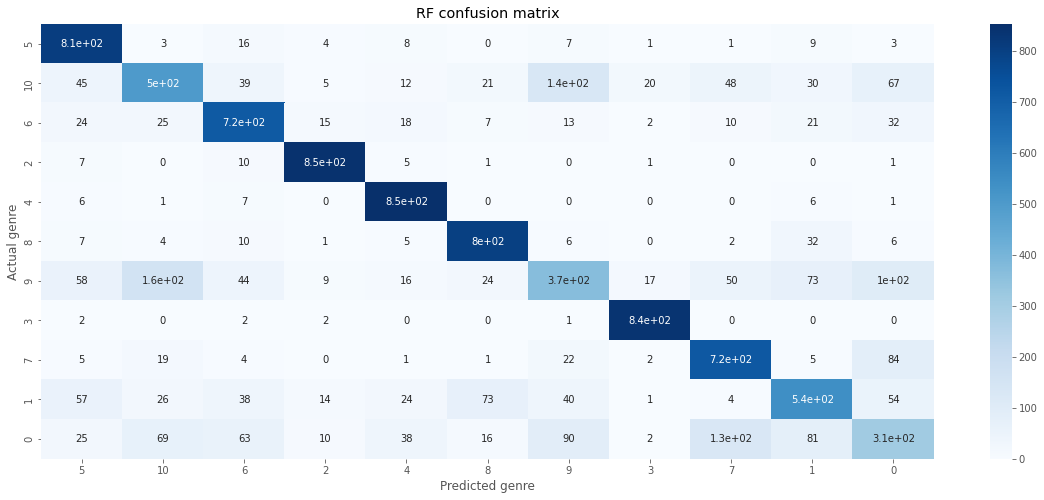

In [126]:
# Print confusion matrix for kNN
rf_confusion = confusion_matrix(y_test.astype(float), prediction)

plt.figure(figsize=(20,8))
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, 
           xticklabels=data['Class'].unique(),
           yticklabels=data['Class'].unique())

plt.xlabel('Predicted genre')
plt.ylabel('Actual genre')
plt.title('RF confusion matrix')
;



**2- Precision, recall, F1 and accuracy scores:**

In [131]:
rf_f1= f1_score(y_test, prediction, average="macro")
rf_precision= precision_score(y_test, prediction, average="macro")
rf_recall= recall_score(y_test, prediction, average="macro")

print("Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(rf_precision, 
                                                     rf_recall,rf_f1))

Precision: 0.7438,   Recall: 0.7614,   F1: 0.7492
